# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
data_dir = 'Cifar10_Images'

# Define transforms
# Train data is augmented my introducing randomness in the input data to help the network generalize. Then the PIL images are converted into PyTorch tensors, since the Normalize transform doesn't support PIL images. 
# Finally the input data is normalized by squishing the values of the different color channels between -1 and 1 centered on zero, which helps keep the network weights near zero which makes the backpropagation more stable.
train_transform = transforms.Compose([ transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# Test data is not altered other than normalized.
test_transform = transforms.Compose([ transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True ,transform=train_transform, download=True)
train_dataloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False ,transform=test_transform, download=True)
test_dataloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    figure = plt.figure(figsize=(8, 6))
    cols, rows = 3, 2
    for i in range(5):
        image = images[i].numpy()
        figure.add_subplot(rows, cols, i+1)
        plt.title(classes[labels[i]])
        plt.imshow(image.T)
    plt.show()

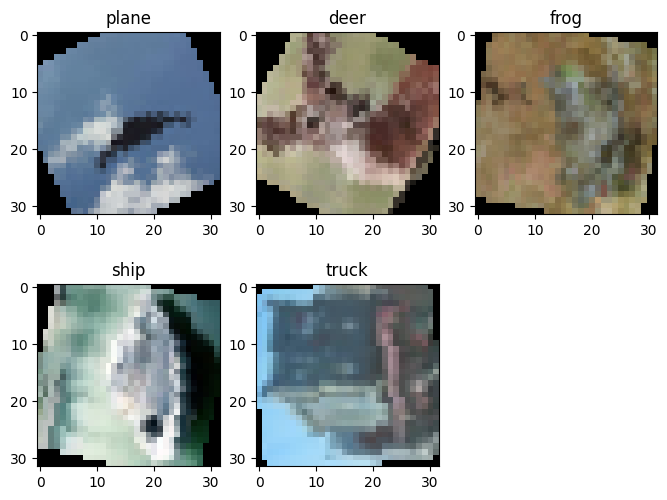

In [4]:
# Explore data
transform = transforms.Compose([ transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

show5(dataloader)

In [5]:
# The following describe the properties of the dataset, which are relevant to know when setting and optimizing the neural network hyperparameters later on.
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature object type: {type(train_features)}")

# Let N = batch size, C = Channels, H = Height of image and W = Width of image :
print(f"Feature batch shape [N, C, H, W]: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature object type: <class 'torch.Tensor'>
Feature batch shape [N, C, H, W]: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(3072,1542) 
        self.fc2 = nn.Linear(1542,771)
        self.fc3 = nn.Linear(771,64)
        # Output layer, 10 units -one for each of the 10 classes.
        self.fc4 = nn.Linear(64,10)

        # Initialize a Dropout module with 0.2 drop probability, which will be used to randomly drop input units with a 20% probability to help prevent overfitting.
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Pass the input tensor through the network, finally returning the output logits
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Instantiate the model
model = Network()

# Define the loss to be the negative log likelihood loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in train_dataloader:
        # Training pass
        # Flattern images to a 3*32*32 = 3072 long vector.
        images = images.view(images.shape[0],-1)

        # Clear gradients from previous pass
        optimizer.zero_grad()

        # Make an inference using the model and compute the loss between input logits and target labels
        logits = model(images)
        loss = criterion(logits,labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else : 
        tot_test_loss = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # For validation we want to use the entire network, therefore we set the dropout probability to 0 by setting the model to evaluation mode.
            model.eval()
            for images, labels in test_dataloader:
                # Flattern images to a 3*32*32 = 3072 long vector.
                images  = images.view(images.shape[0],-1)
                # Make an inference using the model and compute the loss between input logits and target labels
                logits = model(images)
                loss   = criterion(logits,labels)
                tot_test_loss += loss.item()
        
        # Turn the dropout back on.
        model.train()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(train_dataloader.dataset)
        test_loss = tot_test_loss / len(test_dataloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_loss),
            "Testing Loss: {:.3f}.. ".format(test_loss))

Epoch: 1/30..  Training Loss: 0.034..  Testing Loss: 0.032.. 
Epoch: 2/30..  Training Loss: 0.031..  Testing Loss: 0.030.. 
Epoch: 3/30..  Training Loss: 0.029..  Testing Loss: 0.028.. 
Epoch: 4/30..  Training Loss: 0.028..  Testing Loss: 0.027.. 
Epoch: 5/30..  Training Loss: 0.027..  Testing Loss: 0.026.. 
Epoch: 6/30..  Training Loss: 0.026..  Testing Loss: 0.025.. 
Epoch: 7/30..  Training Loss: 0.026..  Testing Loss: 0.025.. 
Epoch: 8/30..  Training Loss: 0.025..  Testing Loss: 0.024.. 
Epoch: 9/30..  Training Loss: 0.025..  Testing Loss: 0.024.. 
Epoch: 10/30..  Training Loss: 0.025..  Testing Loss: 0.024.. 
Epoch: 11/30..  Training Loss: 0.024..  Testing Loss: 0.023.. 
Epoch: 12/30..  Training Loss: 0.024..  Testing Loss: 0.023.. 
Epoch: 13/30..  Training Loss: 0.024..  Testing Loss: 0.023.. 
Epoch: 14/30..  Training Loss: 0.023..  Testing Loss: 0.023.. 
Epoch: 15/30..  Training Loss: 0.023..  Testing Loss: 0.023.. 
Epoch: 16/30..  Training Loss: 0.023..  Testing Loss: 0.022.. 
E

Plot the training loss (and validation loss/accuracy, if recorded).

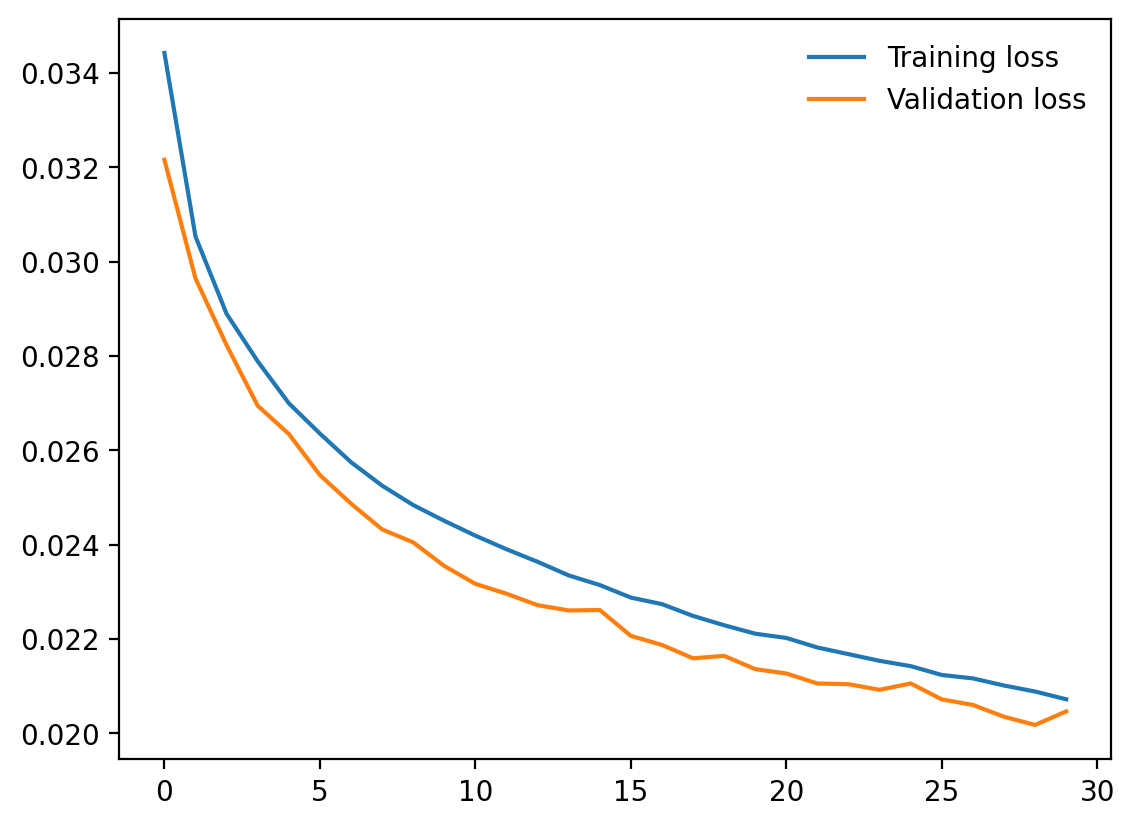

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
test_correct = 0 # Number of correct predictions on the test set

# Turn off gradients for testing, saves memory and computations
with torch.no_grad():
    model.eval()
    for images, labels in test_dataloader:
        # Flattern images to a 3*32*32 = 3072 long vector.
        images  = images.view(images.shape[0],-1)
        # Make an inference using the model and compute the loss between input logits and target labels
        logits = model(images)

        # Calculate the probabilities from the logits
        ps = torch.exp(logits)
        # Get the most likely class and compare with the test label
        top_p,top_class = ps.topk(1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the number of correct predictions
        test_correct += equals.sum().item()

model.train()

print("Test Accuracy: {:.3f}.. ".format(test_correct / len(test_dataloader.dataset)))

Test Accuracy: 0.542.. 


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
checkpoint = {'input_size' : model.fc1.out_features,
              'output_size' : model.fc4.out_features,
              'hidden_layer 1' : model.fc2.out_features,
              'hidden_layer 2' : model.fc3.out_features,
              'state_dict' : model.state_dict()}

torch.save(checkpoint,'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

In this notebook I used simple methods of data augmentation (rotation and horizontal flipping), dropout and a fully connected neural network with 3 hidden layers to get a model, which after training for 30 epochs, gives a test accuracy results of 54.2%. This demonstrates that getting a accuracy rate of 70% is at least not trivial matter.

Further work to improve the accuracy of this in-house solution would be to try other kinds of neural networks, e.g. convolutional neural networks, or do hyperparameter tuning using tools such as the Ray Tune library (ref. https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html#configuring-the-search-space) that are effective at fine tuning the hyperparameters such as learning rate and network layer size. These further approaches, however, are beyond my abilities (as a new machine learning engineer whos only background knowledge with neural networks is the course "Introduction to Neural Networks with PyTorch" from Udacity) and would require time and investment in further upskilling me in these areas.

Of course the price of the object detection algorithm from Detectocorp is a factor that should be considered and should be weighed up by management against the delay, investment and uncertainty of success in upskilling in-house employees. But I would recommend a third option, which is to look into the benchmark sources mentioned in the introduction and see if any of those references have made their models freely available and can thus be used directly or be adapted using transfer learning. It wouldn't require to much time to go through these references to see if the models they have trained have been made available, and transfer learning is a method I (as a student for the course "Introduction to Neural Networks with PyTorch") know and therefore does not require any futher investment in upskilling, and the results would be potentially be between 8.9%-29.0% more accurate than the algorithm from Detectocorp.